# Titanic: Machine Learning from Disaster, by Yoonbo Cho
<br>
This kaggle competition is the research of the infamous sinking of the Titanic. The Competition's Dataset is already conveniently split for us from the train.csv and the test.csv. 

<b>Table of Contents</b>
1. Define the Question and Problem
2. Prepare the Data
    - 2.1 Quick Look
    - 2.2 Outlier Detection
    - 2.3 Filling missing/null values
3. Feature Analysis
    - 3.1 Categorical Values
    - 3.2 Numerical Values
4. Feature Engineering
    - 4.1 Transforming data into categories
    - 4.2 Final Feature Clean up
5. Modeling

## 1. Define the Question and Problem
The Problem as stated by Kaggle:

"In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc)."


The Competition is asking us to determine if a passenger from the disaster, No(0) they didn't survive, and Yes(1) they did. This problem sounds like a classic <b>binary classification</b> problem.

## 2. Prepare the Data

### 2.1 Quick Look

### Import the necessary libraries

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

### Load the Data

In [2]:
# Load the training and test data
train = pd.read_csv("./train.csv")
test = pd.read_csv("./test.csv")

### 2.3 Examine the data
First, the PassengerId and the Ticket column both look like unique identifiers which will not be valuable in solving the question. The two columns will be deleted in order to clean up the data before taking a closer look at all the columns.

Next, while taking a peek at the train and test dataset we can see that:
    - Total samples of train data are 891 while test data is 418
    - Looks like there could be missing features from Age, Cabin, and Embarked but we should double check later.
    - The standard deviation for Age and Fare is something to consider later, possibly binning them would help.
    - The Cabin column has too many missing values so we should delete the feature.

In [3]:
# Preview the data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [5]:
# Checking the data for train and test datasets
print("Train Info")
print(train.info())
print("-"*40)
print("Test Info")
print(test.info())

Train Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
----------------------------------------
Test Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
T

In [6]:
# Before making changes to a Dataframe it is a good practice to make a copy
train_copy = train.copy()

# Delete the PassengerId, Ticket, columns from the copy
train_copy.drop(['PassengerId', 'Ticket'], axis=1, inplace = True)
train_copy.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


In [7]:
train_copy.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 2.2 Outlier Detection
Outliers can cause problems in analyzing data and training the model because they can distort real results.

From the graphs we can pin point on Fare and Sibsp. Starting with Fare, we can see that values above 300 are very rare. It looks like theres values of 500 that if we leave alone, can mess up the results of our training. Next, the values at 8 on the Sibsp should be taken care of as well before moving on.

We can take care of outliers by 

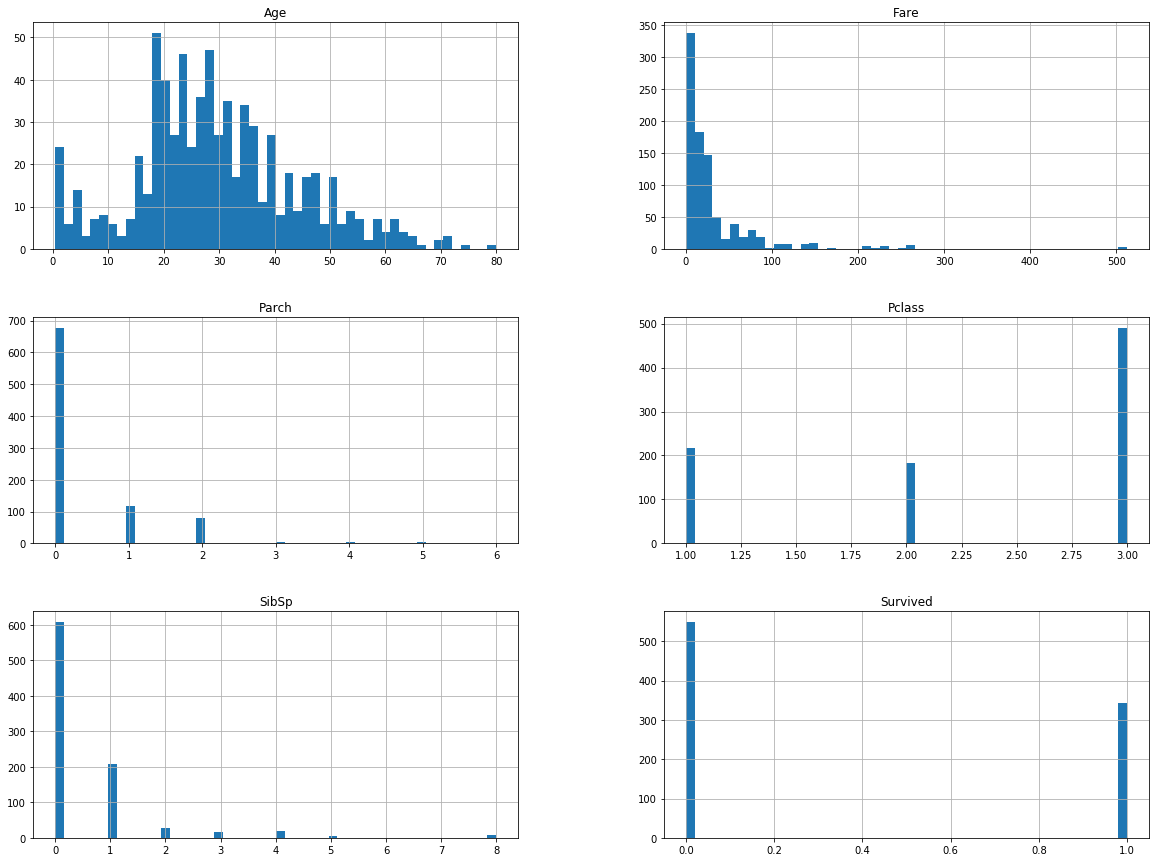

In [8]:
# Using matplotlib to plot the distribution of all the columns
train_copy.hist(bins=50, figsize=(20,15))
plt.show()

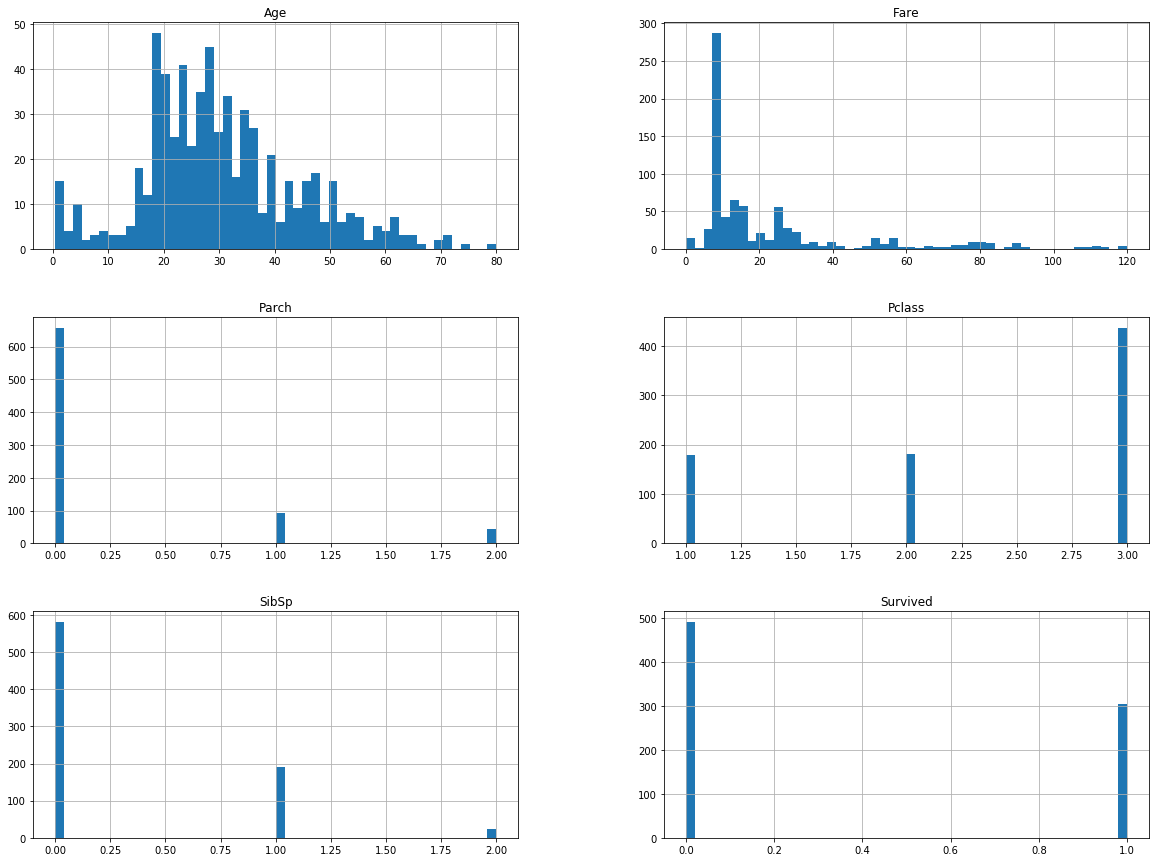

In [9]:
# Algorithm to find and delete the outliers
Q1 = train_copy.quantile(0.15)
Q3 = train_copy.quantile(0.85)
IQR = Q3 - Q1

train_copy = train_copy[~((train_copy < (Q1 - 1.5 * IQR)) |(train_copy > (Q3 + 1.5 * IQR))).any(axis=1)]
train_copy.hist(bins=50, figsize=(20,15))
plt.show()

## 2.3 Filling missing/null values
Leaving missing/null values without treatment can negatively impact your model's performance and here's why:
    - Less data to train from. Especially when working with smaller datasets it is important to be able to use all of it.
    - Some algorithms can't handle null values. Why limit yourself in only selecting a smaller number of algorithms when the one you're missing could be the golden ticket?

In [10]:
# Checking the train and test dataset for null values
print("Train null values")
print(train_copy.isnull().sum())

Train null values
Survived      0
Pclass        0
Name          0
Sex           0
Age         162
SibSp         0
Parch         0
Fare          0
Cabin       622
Embarked      2
dtype: int64


### Methods for filling missing/null values
There are three ways to go about handling missing/null values and they are:
    - Delete the row that contains missing values
    - Delete the entire column of missing values
    - Set the missing value to a certain value for example, the mean, zero, the median, etc.

For this competition I will be going with filling the values with the mean

In [11]:
#complete missing age with median
train_copy['Age'].fillna(train_copy['Age'].median(), inplace = True)

#complete embarked with mode
train_copy['Embarked'].fillna(train_copy['Embarked'].mode()[0], inplace = True)

#complete missing fare with median
train_copy['Fare'].fillna(train_copy['Fare'].median(), inplace = True)

# Replace the Cabin number by the type of cabin 'X' if not
train_copy["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in train_copy['Cabin'] ])
train_copy.loc[ train_copy["Cabin"] == "T", "Cabin"] = "X"

In [12]:
# Checking the train and test dataset for null values
print("Train null values")
print(train_copy.isnull().sum())

Train null values
Survived     0
Pclass       0
Name         0
Sex          0
Age          0
SibSp        0
Parch        0
Fare         0
Cabin       86
Embarked     0
dtype: int64


# 3. Feature Analysis

### 3.1 Categorical Data
Let's divide our focus between categorical and numerical data and take a closer look at the data individually.

### Sex
We can see that majority of women survived reaching a probability of 78% chance of survival. While men only had a 19% chance of survival. That is a drastic difference and it can be because of the saying "Women and children first" putting a higher priority in saving women. 

In [13]:
# distribution of each of the sexes
train_copy["Sex"].value_counts()

male      538
female    258
Name: Sex, dtype: int64

In [14]:
# probability of survived based on Sex
train_copy[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.779070
male,0.193309


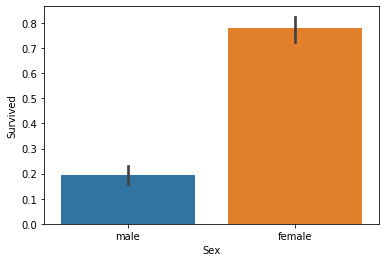

In [15]:
# probability of survived based on Sex shown as a graph
g = sns.barplot(x="Sex", y="Survived", data=train_copy)

### Pclass
The Pclass is the Ticket class and we can see that the more people paid for their tickets, the higher chance of survival they had. As you can see on graph #2, taking a look at Pclass 2 and 3 that even though they paid a lower Fare, all of the children were saved.

In [16]:
# The correlation of Pclass to other numerical features
i_corr = train_copy.corr()
i_corr["Pclass"].sort_values(ascending=False)

Pclass      1.000000
Parch      -0.081534
SibSp      -0.114695
Survived   -0.298240
Age        -0.333965
Fare       -0.715058
Name: Pclass, dtype: float64

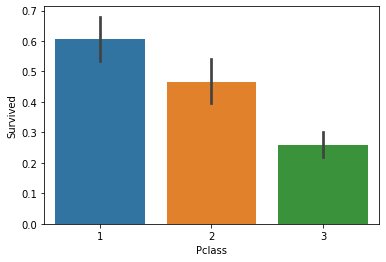

In [17]:
# graph showing the probability of survival based on Pclass
g = sns.barplot(x="Pclass", y="Survived", data=train_copy)

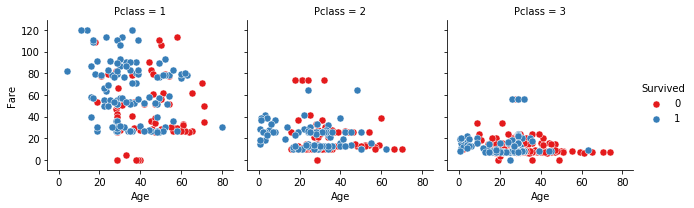

In [18]:
# Scatter plot showing 4 features, the graph is divided into three cateogries which are the Pclass, in each section of the graph
# the x value is the Age, and the y value is the Fare. The colors are represented as red(died) and blue(survived)
kws = dict(s=50, linewidth=.5, edgecolor="w")
g = sns.FacetGrid(train_copy, col="Pclass" , hue="Survived", palette="Set1",)

g = (g.map(plt.scatter, "Age", "Fare", **kws)
     .add_legend())

### Embarked
The letters of Embarked represents Port of Embarkation. The letters are represented as follows, C = Cherbourg, Q = Queenstown, S = Southampton. It seems that more people survived when they reached Cherbourg. Also when the people arrived at their locations, it seems like based on the second graph that women were tended to first as there was a drastic different in male survivability.

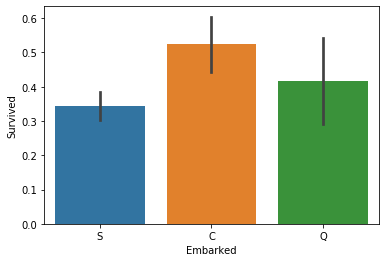

In [19]:
# T
g = sns.barplot(x="Embarked", y="Survived", data=train_copy)

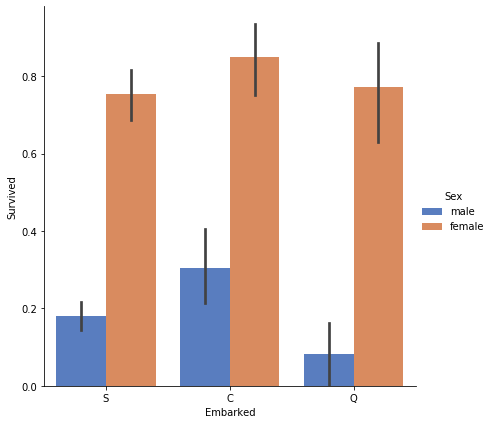

In [20]:
# Explore Pclass vs Survived by Sex
g = sns.catplot(x="Embarked", y="Survived", hue="Sex", data=train_copy,
                   height=6, kind="bar", palette="muted")

### Cabin

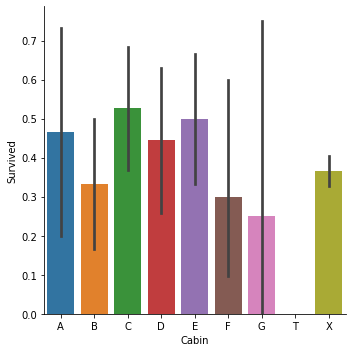

In [21]:
g = sns.catplot(y="Survived",x="Cabin",data=train_copy,kind="bar",order=['A','B','C','D','E','F','G','T','X'])

## 3.2 Numerical Data

### Age
Age played a big role in the survival of the people on board the Titanic. Based on the violin plot, you can see that male children has almost no deaths. As well as female children which have higher probability of survival than older women. 

In [22]:
# show the statistics of the feature Age
train_copy["Age"].describe()

count    796.000000
mean      30.100188
std       12.544500
min        0.420000
25%       23.000000
50%       28.750000
75%       35.000000
max       80.000000
Name: Age, dtype: float64

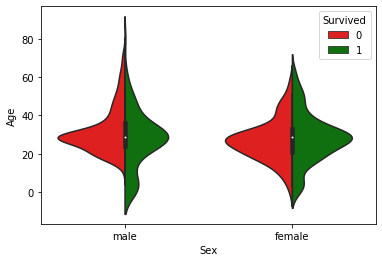

In [23]:
# graphically show the distribution of survived based on Age using a violin plot
g = sns.violinplot(x='Sex', y='Age', 
                     hue='Survived', data=train_copy,
                     split=True,
                     palette={0: "r", 1: "g"},)

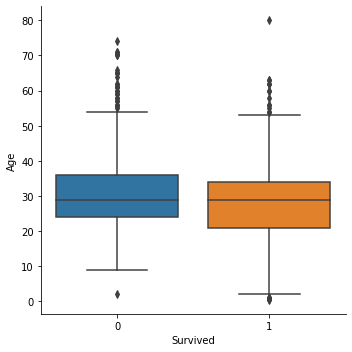

In [24]:
# using a catplot you can see that although a slight difference younger people were more likely to survive.
g = sns.catplot(y="Age",x="Survived",data=train_copy,kind="box")

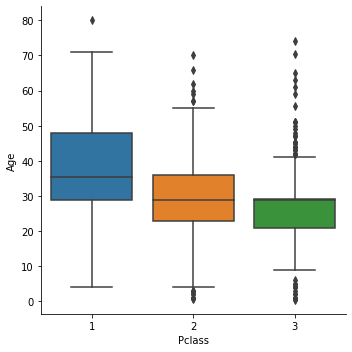

In [25]:
# As the Pclass gets higher(the poorer class) the age goes down. 
g = sns.catplot(y="Age",x="Pclass",data=train_copy,kind="box")

### Fare

In [26]:
# show the statistics of the feature Fare
train_copy["Fare"].describe()

count    796.000000
mean      23.179197
std       24.133193
min        0.000000
25%        7.895800
50%       13.000000
75%       26.550000
max      120.000000
Name: Fare, dtype: float64

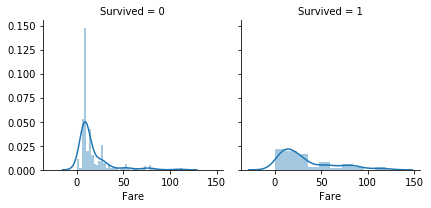

In [27]:
# graph showing the survivability of the passengers based on their fare
g = sns.FacetGrid(train_copy, col='Survived')
g = g.map(sns.distplot, "Fare")

## SibSp
SibSp is the # of siblings / spouses aboard the Titanic. 

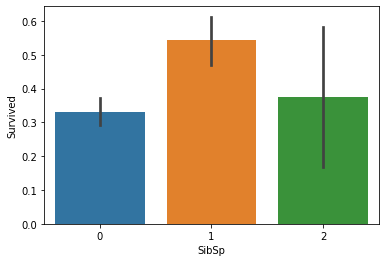

In [28]:
# showing the survivability of passengers based on their SibSp
g = sns.barplot(x="SibSp", y="Survived", data=train_copy)

## Parch
Parch is the # of parents / children aboard the Titanic

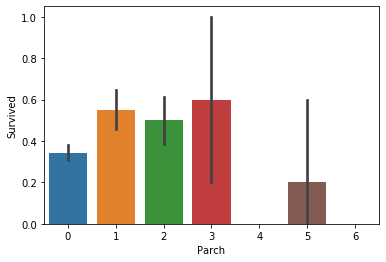

In [29]:
# showing the survivability of passengers based on their Parch
g = sns.barplot(x="Parch", y="Survived", data=train)

# 4. Feature engineering

## Transforming data into categories

### SibSp
We're dividing up the family size into four parts, Single, SmallF(amily), Medf, and LargeF. Creating seperate columns for each category is equivalent to creating dummies.

In [30]:
### Create a family size descriptor from SibSp and Parch ###
train_copy["Fsize"] = train_copy["SibSp"] + train_copy["Parch"] + 1
# Create new feature of family size
train_copy['Single'] = train_copy['Fsize'].map(lambda s: 1 if s == 1 else 0)
train_copy['SmallF'] = train_copy['Fsize'].map(lambda s: 1 if  s == 2  else 0)
train_copy['MedF'] =train_copy['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
train_copy['LargeF'] = train_copy['Fsize'].map(lambda s: 1 if s >= 5 else 0)

### Age
For the feature Age, we're going to be binning them into three different categories. Children, adults, and the elderly. Binning is useful for the effectiveness of the ML algorithm because computers work better with less, smaller numbers.

In [31]:
train_copy["AgeBin"] = train_copy["Age"]

train_copy.loc[ train_copy["AgeBin"] <= 16, "AgeBin"] = 0
train_copy.loc[(train_copy["AgeBin"] > 16) & (train_copy["AgeBin"] <= 40), "AgeBin"] = 1
train_copy.loc[ train_copy["AgeBin"] > 40, "AgeBin"] = 2
train_copy["AgeBin"] = train_copy["AgeBin"].astype(int)

### Title
Extracting Title from names then turning them into dummies is useful because both women, and higher class passengers are more likely to survive. We first extract the title from their names, then map them to a cateogory as seen from the dictioanry. 

In [32]:
# Convert to categorical values Title 
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

# we extract the title from each name
train_copy['Title'] = train_copy['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())

# a map of more aggregated title
# we map each title
train_copy['Title'] = train_copy.Title.map(Title_Dictionary)

### Sex
The feature Sex must be transformed from a string to a int. Computers cannot use strings to form predictions unless its Natural Language Processing. Female is going trasnformed to an 1 while male a 0. 

In [33]:
### Convert Sex to Numerical Data ###
train_copy['Sex'] = train_copy['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

### Embarked
The same thing for Embarked, The letters must be transformed into an int.

In [34]:
### Convert Embarked to Numerical Data ###
train_copy['Embarked'] = train_copy['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

### Combining Features
Combining two features into one can make the two features that were individually not as useful into a more useful feature.

In [35]:
### Combining Two Features into One ###
train_copy['AgeClass'] = train_copy.Age * train_copy.Pclass

In [36]:
train_copy.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Fsize,Single,SmallF,MedF,LargeF,AgeBin,Title,AgeClass
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,X,0,2,0,1,0,0,1,Mr,66.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,1,2,0,1,0,0,1,Mrs,38.0
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,X,0,1,1,0,0,0,1,Miss,78.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,C,0,2,0,1,0,0,1,Mrs,35.0
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,X,0,1,1,0,0,0,1,Mr,105.0


## Final Feature Clean up

### Standard Scaler
the Standard Scaler transforms a numerical feature that was originally a large number into a smaller size. Other types of this method is called normalization, turning a feature into a value between 0 to 1.

In [37]:
# Get the list of all the float features in the dataset
train_numerical_features = list(train_copy.select_dtypes(include=['float64']).columns)
# Initialize the Standard Scaler Object
ss_scaler = StandardScaler()
# Fit and Transform the float features using the Standard Scaler
train_copy[train_numerical_features] = ss_scaler.fit_transform(train_copy[train_numerical_features])

### Convert data to dummies
Converting data to dummies is equivalent to using a One Hot Encoding. By Seperating the categories of features into seperate columns the values are either 0 or 1. The computer does a better job with simpler numbers.

In [38]:
# The list of all the features that are going to turn into dummies
dummy_list = ['Title', 'Embarked', 'Pclass', 'Sex', 'AgeBin', 'Cabin']
# Transform the Pclass feature into a category feature
train_copy["Pclass"] = train_copy["Pclass"].astype("category")

# Iterate through the dummy_list and transform all the features in the list into dummies
for i in dummy_list:
    train_copy = pd.get_dummies(train_copy, prefix=i, columns=[i])

### Drop the unnecessary features

In [39]:
# After transforming the features into dummies we no longer need these features
drop_list = ["SibSp", "Fsize", "Name", "Age"]
train_copy.drop(drop_list, axis=1, inplace=True)

In [40]:
train_copy.head()

,Survived,Parch,Fare,Single,SmallF,MedF,LargeF,AgeClass,Title_Master,Title_Miss,...,AgeBin_1,AgeBin_2,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_X
0,0,0,-0.660468,0,1,0,0,-0.018193,0,0,...,1,0,0,0,0,0,0,0,0,1
1,1,0,1.994529,0,1,0,0,-0.903189,0,0,...,1,0,0,0,1,0,0,0,0,0
2,1,0,-0.632481,1,0,0,0,0.361092,0,1,...,1,0,0,0,0,0,0,0,0,1
3,1,0,1.240599,0,1,0,0,-0.998010,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,0,-0.627298,1,0,0,0,1.214481,0,0,...,1,0,0,0,0,0,0,0,0,1


# 5. Model
I tried out three different classifiers, Random Forest, Gradient Boosting, and SVC. I used GridSearchCV to search for the best parameters that fit the model. As we can see from the feature importance, The sex has a high importance as well as the Fare as we deducted before in our analysis. Finally, after fitting all the classifiers, the models were then combined using ensembling. Ensembling is beneficial in producing a higher quality prediction by taking all the best parts of each classifier and combining it into one.

In [41]:
# Drop the feature Passenger ID
testID = test["PassengerId"]
test.drop("PassengerId", axis=1, inplace=True)
train.drop("PassengerId", axis=1, inplace=True)

In [42]:
## Separate train features and label 
train_copy["Survived"] = train_copy["Survived"].astype(int)

targets = train_copy["Survived"]

train_copy = train_copy.drop(labels = ["Survived"],axis = 1)

In [64]:
# Using GridSearchCV to search for the best paramters for fitting the RandomForestClassifier
parameter_grid = {
             'max_depth' : [4, 6, 8],
             'n_estimators': [50, 10],
             'max_features': ['sqrt', 'auto', 'log2'],
             'min_samples_split': [2, 3, 10],
             'min_samples_leaf': [1, 3, 10],
             'bootstrap': [True, False],
             }
forest = RandomForestClassifier()
cross_validation = StratifiedKFold(n_splits=5)

grid_search = GridSearchCV(forest,
                           scoring='accuracy',
                           param_grid=parameter_grid,
                           cv=cross_validation,
                           verbose=1
                          )

grid_search.fit(train_copy, targets)
model = grid_search
RFC_best = grid_search.best_estimator_

print('Best score: {}'.format(grid_search.best_score_))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score: 0.8279009433962263


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  1.2min finished


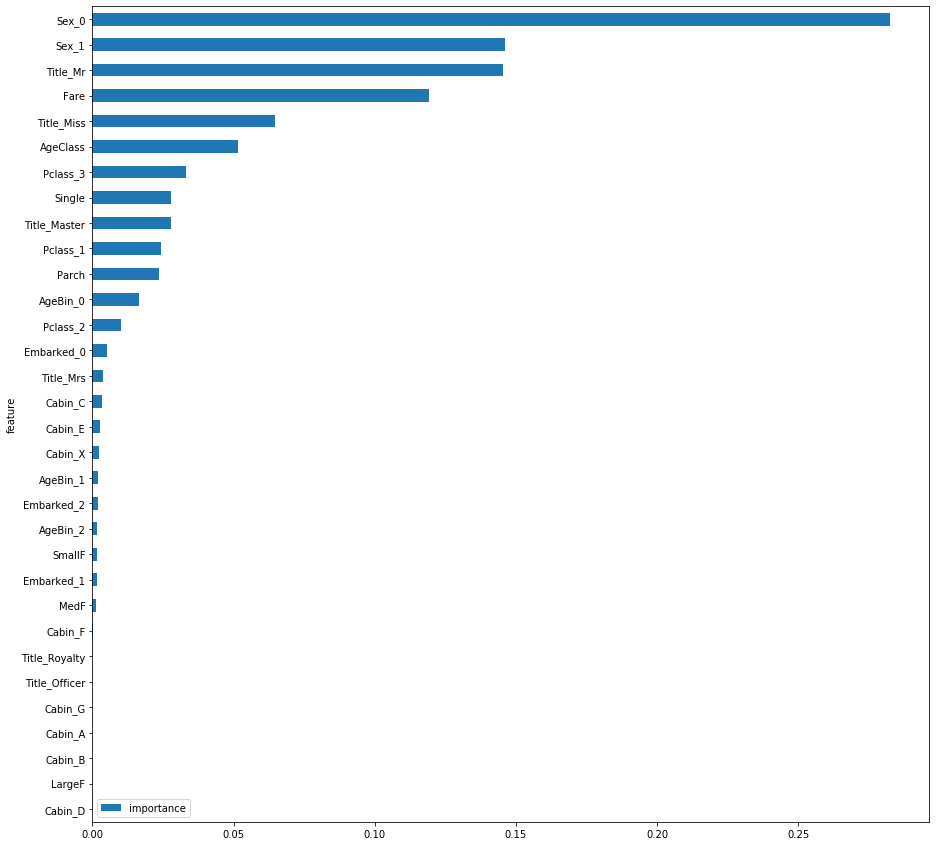

In [47]:
# Create a new Dataframe called features
features = pd.DataFrame()
# Copy the features from the original dataset into a series called feature
features['feature'] = train_copy.columns
# Create a series called importance and input the feature importances from the model
features['importance'] = grid_search.best_estimator_.feature_importances_
# Sort then plot the values using matplotlib
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(15, 15))

In [59]:
# Using GridSearchCV to search for the best paramters for fitting the GradientBoosting Classifier
kfold = StratifiedKFold(n_splits=10)

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(train_copy,targets)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.5s
[Parallel(n_jobs=4)]: Done 336 tasks      | elapsed:   24.3s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   42.5s finished


0.8191139240506329

In [62]:
# Using GridSearchCV to search for the best paramters for fitting the SVC
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(train_copy,targets)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   28.8s finished


0.826613924050633

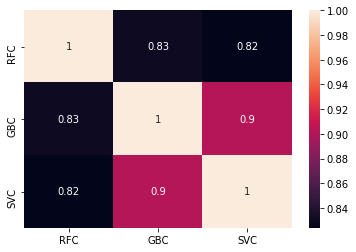

In [66]:
# make a prediction using the classifiers
test_Survived_RFC = pd.Series(RFC_best.predict(train_copy), name="RFC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(train_copy), name="SVC")
test_Survived_GBC = pd.Series(GBC_best.predict(train_copy), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_GBC, test_Survived_SVMC],axis=1)

# Show the correlation between the models
g= sns.heatmap(ensemble_results.corr(),annot=True)

In [69]:
# Ensemble the classifiers using the VotingClassifier
votingC = VotingClassifier(estimators=[('rfc', RFC_best),
('svc', SVMC_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(train_copy, targets)